# PROJECT : Predicting players rating

In [1]:
import sqlite3
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

In [2]:
cnx = sqlite3.connect('database.sqlite')
cnx

In [3]:
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [4]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [5]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [6]:
df.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [7]:
df.shape

(183978, 42)

In [8]:
[(f"column {i+1} : {column}") 
 for i,column in enumerate(df.columns)]

['column 1 : id',
 'column 2 : player_fifa_api_id',
 'column 3 : player_api_id',
 'column 4 : date',
 'column 5 : overall_rating',
 'column 6 : potential',
 'column 7 : preferred_foot',
 'column 8 : attacking_work_rate',
 'column 9 : defensive_work_rate',
 'column 10 : crossing',
 'column 11 : finishing',
 'column 12 : heading_accuracy',
 'column 13 : short_passing',
 'column 14 : volleys',
 'column 15 : dribbling',
 'column 16 : curve',
 'column 17 : free_kick_accuracy',
 'column 18 : long_passing',
 'column 19 : ball_control',
 'column 20 : acceleration',
 'column 21 : sprint_speed',
 'column 22 : agility',
 'column 23 : reactions',
 'column 24 : balance',
 'column 25 : shot_power',
 'column 26 : jumping',
 'column 27 : stamina',
 'column 28 : strength',
 'column 29 : long_shots',
 'column 30 : aggression',
 'column 31 : interceptions',
 'column 32 : positioning',
 'column 33 : vision',
 'column 34 : penalties',
 'column 35 : marking',
 'column 36 : standing_tackle',
 'column 37 : sl

In [9]:
soccer_data = df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1)

soccer_data.duplicated().any()

True

In [10]:
soccer_data.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [11]:
soccer_data.drop_duplicates(inplace=True)

soccer_data.shape

(138440, 38)

In [12]:
soccer_data.isnull().values.sum()

12216

In [13]:
def data_preprocessing(df):
    df.convert_objects(convert_numeric=True)
    df.fillna(-11111, inplace=True)     
    return df

data_preprocessing(soccer_data)

soccer_data.isnull().values.sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


0

In [14]:
soccer_data.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,32.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


In [15]:
soccer_data = pd.get_dummies(soccer_data)
soccer_data.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,0,0,0,0,0,0,1,0,0,0
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,0,0,0,0,0,0,1,0,0,0
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,0,0,0,0,0,0,1,0,0,0
5,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,...,0,0,0,0,0,0,1,0,0,0
6,74.0,76.0,80.0,53.0,58.0,71.0,32.0,73.0,70.0,69.0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
soccer_data.shape

(138440, 67)

In [17]:
soccer_data.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
count,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,...,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000
mean,69.214302,73.916130,55.443983,50.113710,57.692264,62.881436,-69.586362,59.402781,-66.194481,49.702557,...,0.000845,0.013081,0.000621,0.000730,0.154226,0.099191,0.707563,0.009715,0.002124,0.000506
std,30.821850,30.766953,34.721983,35.661284,34.390315,33.262384,1148.715912,34.990261,1149.067847,35.019908,...,0.029059,0.113624,0.024916,0.027001,0.361166,0.298919,0.454884,0.098087,0.046034,0.022481
min,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,65.000000,69.000000,46.000000,34.000000,50.000000,58.000000,35.000000,52.000000,41.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,74.000000,60.000000,53.000000,60.000000,66.000000,53.000000,64.000000,56.000000,51.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,74.000000,78.000000,68.000000,66.000000,69.000000,72.000000,64.000000,72.000000,67.000000,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


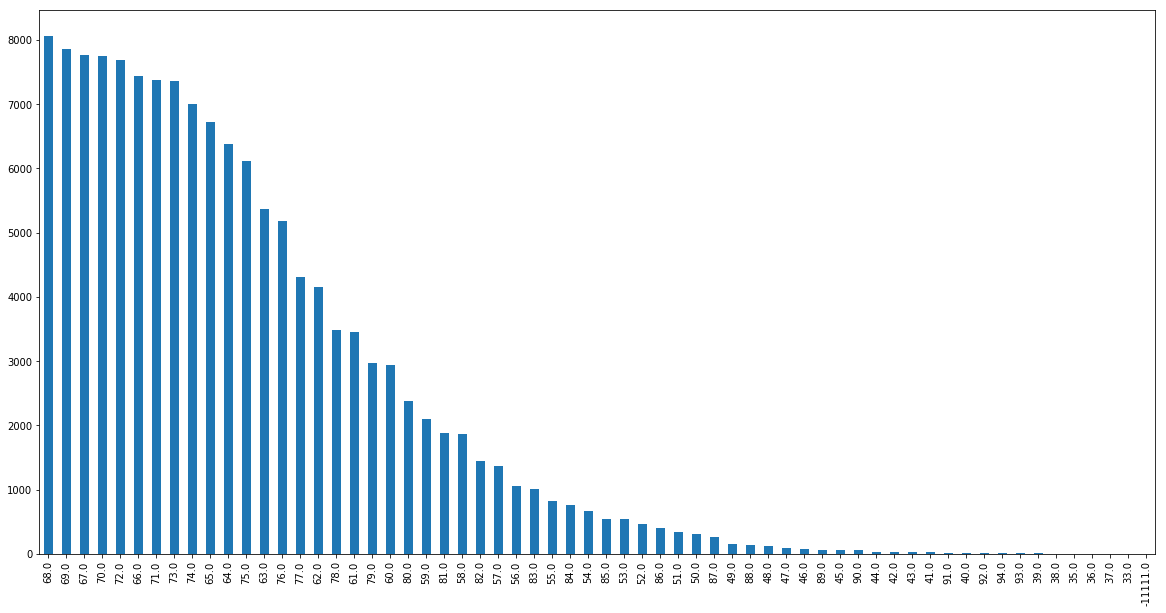

In [18]:
soccer_data['overall_rating'].value_counts()
soccer_data['overall_rating'].value_counts().plot(kind='bar',figsize=(20,10))

In [19]:
df_x = soccer_data.drop(['overall_rating'], 1)
df_y = np.array(soccer_data['overall_rating'])

In [20]:
rfc_1 = RandomForestRegressor(random_state=10)
rfc_1.fit(df_x, df_y)

feature_importances = pd.DataFrame({'feature':df_x.columns,'importance':np.round(rfc_1.feature_importances_,4)})
feature_importances = feature_importances.sort_values('importance',ascending=False).set_index('feature')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
print(feature_importances[:36])

                        importance
feature                           
gk_kicking                  0.1928
ball_control                0.1026
strength                    0.0992
dribbling                   0.0985
penalties                   0.0978
positioning                 0.0966
crossing                    0.0962
long_passing                0.0955
reactions                   0.0641
potential                   0.0326
standing_tackle             0.0059
gk_diving                   0.0032
heading_accuracy            0.0023
gk_positioning              0.0019
marking                     0.0014
interceptions               0.0010
shot_power                  0.0010
finishing                   0.0010
gk_handling                 0.0009
short_passing               0.0006
stamina                     0.0006
gk_reflexes                 0.0005
aggression                  0.0005
long_shots                  0.0004
sliding_tackle              0.0004
sprint_speed                0.0004
curve               

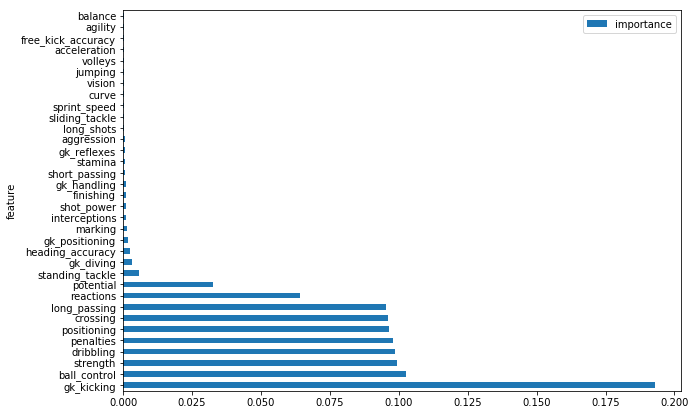

In [22]:
feature_importances[:34].plot(kind='barh',figsize=(10,7))

In [23]:
x, x_test, y, y_test = train_test_split(df_x,df_y,test_size=0.2,train_size=0.8, random_state = 55)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.20,train_size =0.80, random_state = 55)

In [24]:
from sklearn.preprocessing import StandardScaler, Normalizer, scale
df_x1 = scale(x_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


In [25]:
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score

pca = PCA(n_components=10).fit(x_train)

In [26]:
pca.explained_variance_ratio_

array([9.95039485e-01, 4.19000158e-03, 3.15578272e-04, 2.13454604e-04,
       4.00645667e-05, 3.60343282e-05, 2.48869067e-05, 1.27652523e-05,
       1.17663081e-05, 1.07459731e-05])

In [27]:
from sklearn.decomposition import PCA

df_x2 = pca.transform(x_train)


pca.transform(x_test)

array([[-3.34424396e+02, -2.04024753e+01,  3.83980156e+01, ...,
         6.18736908e+00, -1.04000138e+01, -5.83079897e+00],
       [-3.58687397e+02, -6.54036636e+01,  5.05352164e+01, ...,
         1.25437916e+00,  1.26458549e+00,  5.59773842e+00],
       [-3.35481023e+02, -3.22487848e+01,  3.15452861e+00, ...,
         8.95188515e+00,  2.14401843e+01, -8.39214402e+00],
       ...,
       [-3.00677429e+02,  1.41100047e+01,  4.37305998e+00, ...,
        -8.37394767e+00, -2.54347312e+00,  1.36869878e+01],
       [-3.21875261e+02,  1.56720608e+01,  2.19823881e+01, ...,
        -3.44636472e+00,  2.28364962e+00,  2.24988138e-02],
       [-3.23319007e+02,  3.20782029e+01, -1.33406377e+01, ...,
        -3.31350017e+00,  4.41076601e-01,  1.74103252e+01]])

In [28]:
pca.transform(x_cv)

array([[-327.98837729,  -25.02027219,   34.80464507, ...,    8.40803936,
         -20.33276515,   10.48635304],
       [-349.97064925,  -40.10109918,   54.92183519, ...,    2.68956211,
           1.5865401 ,   -1.24235434],
       [-325.28641053,   11.66869071,   33.85678369, ...,  -10.38343828,
          11.11145752,   -6.88400644],
       ...,
       [-289.66069731,   30.70117491,  -14.50483973, ...,   11.34630702,
         -17.62833121,    0.70311042],
       [-313.60003496,    2.62963249,   24.07809931, ...,    9.95737458,
          -9.38366829,   -8.27027468],
       [-326.83761153,  -18.25013055,   26.2576438 , ...,    7.8612269 ,
          11.05022052,    9.70687131]])

In [29]:
lr1 = LinearRegression()
lr = RFE(lr1, 20)
lr.fit(x_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=20, step=1, verbose=0)

In [30]:
d_tree = DecisionTreeRegressor(min_samples_split=10, random_state=55)
d_tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=55, splitter='best')

In [31]:
rfc = RandomForestRegressor(random_state=99)
rfc.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=99, verbose=0, warm_start=False)

In [32]:
Boosting = xgb.XGBRegressor(n_estimators=200,learning_rate=1)
Boosting.fit(x_train,y_train)

[12:44:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [33]:
models = pd.DataFrame(index=['train_mse','cv_mse','test_mse','accuracy_score'], columns=['linear_regression','decision_tree','random_forest','xgboost'])

In [34]:
models.loc['train_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_train), y_true=y_train)
models.loc['cv_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_cv), y_true=y_cv)
models.loc['test_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_test), y_true=y_test)
models.loc['accuracy_score','linear_regression'] = accuracy_score(y_pred=lr.predict(x_test).round(), y_true=y_test)

In [35]:
models.loc['train_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_train), y_true=y_train)
models.loc['cv_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_cv), y_true=y_cv)
models.loc['test_mse','decision_tree'] = mean_squared_error(y_pred=d_tree.predict(x_test), y_true=y_test)
models.loc['accuracy_score','decision_tree'] = accuracy_score(y_pred=d_tree.predict(x_test).round(), y_true=y_test)

models.loc['train_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_train), y_true=y_train)
models.loc['cv_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_cv), y_true=y_cv)
models.loc['test_mse','random_forest'] = mean_squared_error(y_pred=rfc.predict(x_test), y_true=y_test)
models.loc['accuracy_score','random_forest'] = accuracy_score(y_pred=rfc.predict(x_test).round(), y_true=y_test)

models.loc['train_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_train), y_true=y_train)
models.loc['cv_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_cv), y_true=y_cv)
models.loc['test_mse','xgboost'] = mean_squared_error(y_pred=Boosting.predict(x_test), y_true=y_test)
models.loc['accuracy_score','xgboost'] = accuracy_score(y_pred=Boosting.predict(x_test).round(), y_true=y_test)

In [36]:
models

,linear_regression,decision_tree,random_forest,xgboost
train_mse,1440.6,0.389921,351.463,1.64605
cv_mse,61.244,3.20427,1.69886,1.92968
test_mse,61.061,3.09212,1.60405,1.88664
accuracy_score,0.0571728,0.439613,0.503828,0.344734


# we can say that random_forest is giving highest accuracy and less error.